# Distilled Student Model Training, Retrieval & Evaluation

This notebook trains a text-only `StudentModel` via knowledge distillation from a pre-trained `TeacherModel`, implements a retrieval function that uses the distilled student model, and computes recall@1/5/10/20, test MSE (student vs teacher), and average cosine similarity.

The distillation process uses a hybrid loss: `Loss = alpha * MSE(student, teacher) + (1-alpha) * MSE(student, glove)` with `alpha=0.5` by default.

Notes:
- Make sure required packages are installed: `numpy`, `torch`, `transformers`, `torchvision`, `tqdm`, `scikit-learn`, `matplotlib`.
- Training on CPU can be slow. Consider running on GPU if available.
- The teacher model must be pre-trained and available at `./ckpts/teacher_model.pt`.


In [1]:
# Environment check and imports
try:
    import torch, numpy as np
    import transformers
    import torchvision
    print('Found: torch, numpy, transformers, torchvision')
except Exception as e:
    print('Missing packages. Install with:')
    print('  python3 -m pip install numpy torch transformers torchvision tqdm scikit-learn')
    raise

# Imports from project
from distillation import (
    create_distillation_dataset,
    train_distillation_epoch,
    evaluate_distillation,
)
from teacher import (
    TeacherModel,
    load_glove_embeddings,
    collate_examples,
)
from student import (
    StudentModel,
    TextOnlyDataset,
)

from pathlib import Path
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

print('Imports OK')


/Users/catherineli/UMD/CMSC498K/Final Project/ReverseDictionary/.venv/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Found: torch, numpy, transformers, torchvision
Imports OK


In [2]:
# Config
DATASET = 'dataset.json'
GLOVE = './glove.6B.300d.txt'
BERT = 'bert-base-uncased'
BATCH = 8
EPOCHS = 15
LR = 2e-5
MAXLEN = 128
ALPHA = 0.5
DEVICE = torch.device('cuda' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu'))
print('Device:', DEVICE)


Device: mps


In [3]:
# Load GloVe and dataset
print('Loading GloVe...')
glove = load_glove_embeddings(GLOVE)
print('GloVe dim =', next(iter(glove.values())).shape[0])

print('Loading distillation dataset...')
ds = create_distillation_dataset(DATASET, glove, tokenizer_name=BERT, max_length=MAXLEN)

n = len(ds)
print('Dataset size:', n)

# random 90/10 split
import random
indices = list(range(n))
random.shuffle(indices)
train_n = int(0.9 * n)
train_idx = indices[:train_n]
test_idx = indices[train_n:]

train_ds = torch.utils.data.Subset(ds, train_idx)
test_ds = torch.utils.data.Subset(ds, test_idx)

train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True, collate_fn=lambda x: collate_examples(x))
val_loader = DataLoader(test_ds, batch_size=BATCH, shuffle=False, collate_fn=lambda x: collate_examples(x))

print('Train size:', len(train_ds), 'Test size:', len(test_ds))


Loading GloVe...
GloVe dim = 300
Loading distillation dataset...
Dataset size: 971
Train size: 873 Test size: 98


In [4]:
# Load pre-trained teacher and initialize student model
print('Loading teacher model...')
teacher = TeacherModel(bert_model_name=BERT, target_dim=next(iter(glove.values())).shape[0])
teacher_path = Path('./ckpts/teacher_model_w_dropout=0.2.pt')
if teacher_path.exists():
    teacher.load_state_dict(torch.load(teacher_path, map_location=DEVICE))
    print(f'Loaded teacher from {teacher_path}')
else:
    print(f'Warning: Teacher model not found at {teacher_path}')

teacher.to(DEVICE)
teacher.eval()
for param in teacher.parameters():
    param.requires_grad = False

print('Initializing student model...')
student = StudentModel(bert_model_name=BERT, target_dim=next(iter(glove.values())).shape[0])
student.to(DEVICE)

print('Models ready; training will run for', EPOCHS, 'epochs with alpha =', ALPHA)


Loading teacher model...


/Users/catherineli/UMD/CMSC498K/Final Project/ReverseDictionary/.venv/lib/python3.14/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/catherineli/UMD/CMSC498K/Final Project/ReverseDictionary/.venv/lib/python3.14/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loaded teacher from ckpts/teacher_model_w_dropout=0.2.pt
Initializing student model...
Models ready; training will run for 15 epochs with alpha = 0.5


In [5]:
losses = []
teacher_mses = []
glove_mses = []
hybrid_mses = []

# Re-import to ensure we get the latest version of distillation functions
import importlib
import distillation
importlib.reload(distillation)
from distillation import train_distillation_epoch, evaluate_distillation

# Training loop (15 epochs with distillation)
for epoch in range(1, EPOCHS + 1):
    train_loss = train_distillation_epoch(
        student, teacher, train_ds,
        batch_size=BATCH,
        device=DEVICE,
        lr=LR,
        temperature=1.0,
        alpha=ALPHA,
    )
    
    val_hybrid_mse, val_teacher_mse, val_glove_mse, val_cosine = evaluate_distillation(
        student, teacher, test_ds,
        batch_size=BATCH,
        device=DEVICE,
        alpha=ALPHA,
    )
    
    print(f"Epoch {epoch}: train_loss={train_loss:.6f} val_hybrid_mse={val_hybrid_mse:.6f} val_teacher_mse={val_teacher_mse:.6f} val_glove_mse={val_glove_mse:.6f}")
    
    losses.append(train_loss)
    hybrid_mses.append(val_hybrid_mse)
    teacher_mses.append(val_teacher_mse)
    glove_mses.append(val_glove_mse)
    
    # Save best model based on hybrid MSE
    if len(hybrid_mses) > 0 and val_hybrid_mse == min(hybrid_mses):
        model_path = Path('./ckpts/student_distilled_w_dropout.pt')
        model_path.parent.mkdir(parents=True, exist_ok=True)
        torch.save(student.state_dict(), model_path)
        print('Saved best model to', model_path)


Epoch 1: train_loss=0.088806 val_hybrid_mse=0.076681 val_teacher_mse=0.023945 val_glove_mse=0.129417
Saved best model to ckpts/student_distilled_w_dropout.pt


Epoch 2: train_loss=0.072577 val_hybrid_mse=0.072541 val_teacher_mse=0.019939 val_glove_mse=0.125144
Saved best model to ckpts/student_distilled_w_dropout.pt


Epoch 3: train_loss=0.067668 val_hybrid_mse=0.069621 val_teacher_mse=0.017281 val_glove_mse=0.121960
Saved best model to ckpts/student_distilled_w_dropout.pt


Epoch 4: train_loss=0.064459 val_hybrid_mse=0.067475 val_teacher_mse=0.015417 val_glove_mse=0.119533
Saved best model to ckpts/student_distilled_w_dropout.pt


Epoch 5: train_loss=0.061764 val_hybrid_mse=0.066216 val_teacher_mse=0.014640 val_glove_mse=0.117792
Saved best model to ckpts/student_distilled_w_dropout.pt


Epoch 6: train_loss=0.059324 val_hybrid_mse=0.065021 val_teacher_mse=0.013769 val_glove_mse=0.116273
Saved best model to ckpts/student_distilled_w_dropout.pt


Epoch 7: train_loss=0.057277 val_hybrid_mse=0.065147 val_teacher_mse=0.014114 val_glove_mse=0.116180


Epoch 8: train_loss=0.055667 val_hybrid_mse=0.064660 val_teacher_mse=0.014298 val_glove_mse=0.115021
Saved best model to ckpts/student_distilled_w_dropout.pt


Epoch 9: train_loss=0.054354 val_hybrid_mse=0.064068 val_teacher_mse=0.013964 val_glove_mse=0.114172
Saved best model to ckpts/student_distilled_w_dropout.pt


Epoch 10: train_loss=0.053249 val_hybrid_mse=0.064223 val_teacher_mse=0.014255 val_glove_mse=0.114191


Epoch 11: train_loss=0.052629 val_hybrid_mse=0.063841 val_teacher_mse=0.014561 val_glove_mse=0.113121
Saved best model to ckpts/student_distilled_w_dropout.pt


Epoch 12: train_loss=0.051346 val_hybrid_mse=0.063681 val_teacher_mse=0.014309 val_glove_mse=0.113053
Saved best model to ckpts/student_distilled_w_dropout.pt


Epoch 13: train_loss=0.050439 val_hybrid_mse=0.063968 val_teacher_mse=0.015152 val_glove_mse=0.112785


Epoch 14: train_loss=0.049893 val_hybrid_mse=0.064296 val_teacher_mse=0.015471 val_glove_mse=0.113122


Epoch 15: train_loss=0.049030 val_hybrid_mse=0.063803 val_teacher_mse=0.015504 val_glove_mse=0.112101


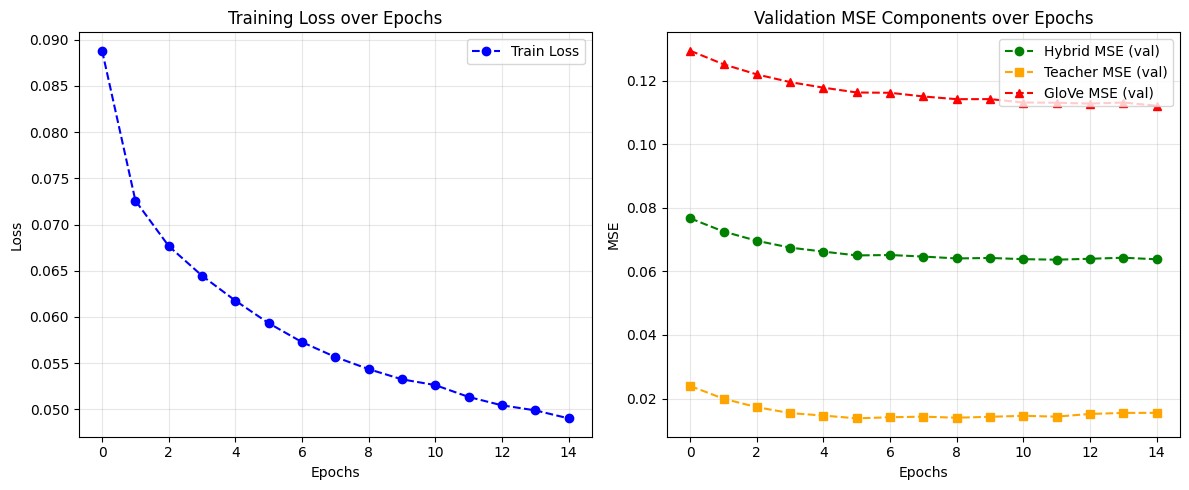

In [6]:
import matplotlib.pyplot as plt

x = range(EPOCHS)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(x, losses, color='blue', marker='o', linestyle='--', label='Train Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.grid(True, alpha=0.3)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x, hybrid_mses, color='green', marker='o', linestyle='--', label='Hybrid MSE (val)')
plt.plot(x, teacher_mses, color='orange', marker='s', linestyle='--', label='Teacher MSE (val)')
plt.plot(x, glove_mses, color='red', marker='^', linestyle='--', label='GloVe MSE (val)')
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.title("Validation MSE Components over Epochs")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [7]:
# Prepare DB vectors (GloVe) for retrieval (full dataset)
db_words = [ex['word'] for ex in ds.examples]
db_defs = [ex['definition'] for ex in ds.examples]
db_vectors = np.stack([ex['vector'] for ex in ds.examples])
# normalize
db_norms = np.linalg.norm(db_vectors, axis=1)
db_norms[db_norms == 0] = 1.0

# retrieval: definition -> use distilled student model to get query vector

def retrieve_topk(definition: str, k: int = 10, model=student, ds=ds, device=DEVICE):
    # tokenize definition
    toks = ds.tokenizer(definition, truncation=True, padding='max_length', max_length=ds.max_length, return_tensors='pt')
    input_ids = toks['input_ids'].to(device)
    attention_mask = toks['attention_mask'].to(device)

    model.eval()
    with torch.no_grad():
        q = model(input_ids=input_ids, attention_mask=attention_mask)
    q = q.cpu().numpy().reshape(-1)
    q_norm = np.linalg.norm(q)
    if q_norm == 0:
        q_norm = 1.0
    sims = (db_vectors @ q) / (db_norms * q_norm)
    idxs = np.argsort(-sims)[:k]
    return [(db_words[i], db_defs[i], float(sims[i])) for i in idxs]

print('Retrieval helper ready')


Retrieval helper ready


In [8]:
# Evaluate recall@1,5,10,20, test MSE (student vs teacher), and average cosine similarity
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity

k_values = [1,5,10,20]
correct = defaultdict(int)
num_test = len(test_idx)
ranks = []

total_mse = 0.0
total_cos = 0.0

for idx in tqdm(test_idx, desc='Evaluating test set'):
    # get sample from dataset
    sample = ds[idx]
    input_ids = sample['input_ids'].unsqueeze(0).to(DEVICE)
    attention_mask = sample['attention_mask'].unsqueeze(0).to(DEVICE)
    image = sample['image'].unsqueeze(0).to(DEVICE)
    gt_vec = sample['vector'].numpy()
    gt_word = sample['word']

    student.eval()
    teacher.eval()
    with torch.no_grad():
        student_pred = student(input_ids=input_ids, attention_mask=attention_mask)
        teacher_pred = teacher(input_ids=input_ids, attention_mask=attention_mask, image=image, training=False)
    
    student_np = student_pred.cpu().numpy().reshape(-1)
    teacher_np = teacher_pred.cpu().numpy().reshape(-1)

    # MSE between student and teacher
    mse = np.mean((student_np - teacher_np) ** 2)
    total_mse += mse

    # cosine similarity between student and teacher
    cos = np.dot(student_np, teacher_np) / (np.linalg.norm(student_np) * (np.linalg.norm(teacher_np) if np.linalg.norm(teacher_np)>0 else 1.0))
    total_cos += cos

    # retrieval using student embedding
    sims = (db_vectors @ student_np) / (db_norms * (np.linalg.norm(student_np) if np.linalg.norm(student_np)>0 else 1.0))
    idxs = np.argsort(-sims)[:len(ds)]
    retrieved = [db_words[i] for i in idxs]

    for k in k_values:
        if sample['word'] in retrieved[:k]:
            correct[k] += 1

    # Find rank of ground truth word (1-indexed)
    if gt_word in retrieved:
        rank = retrieved.index(gt_word) + 1
        ranks.append(rank)
    else:
        # If not found, append length of database
        ranks.append(len(db_words))

# Final metrics
avg_mse = total_mse / num_test
avg_cos = total_cos / num_test

print(f'Num test examples: {num_test}')
for k in k_values:
    print(f'Recall@{k}: {correct[k]}/{num_test} = {correct[k]/num_test:.4f}')
print(f'Test MSE (student vs teacher): {avg_mse:.6f}')
print(f'Average cosine similarity (student vs teacher): {avg_cos:.6f}')
median_rank = np.median(ranks)
average_rank = np.mean(ranks)
print(f'Median Rank: {median_rank:.1f}')
print(f'Average Rank: {average_rank:.2f}')


Evaluating test set: 100%|██████████| 98/98 [00:03<00:00, 27.65it/s]

Num test examples: 98
Recall@1: 7/98 = 0.0714
Recall@5: 21/98 = 0.2143
Recall@10: 30/98 = 0.3061
Recall@20: 42/98 = 0.4286
Test MSE (student vs teacher): 0.015321
Average cosine similarity (student vs teacher): 0.756700
Median Rank: 37.5
Average Rank: 90.68


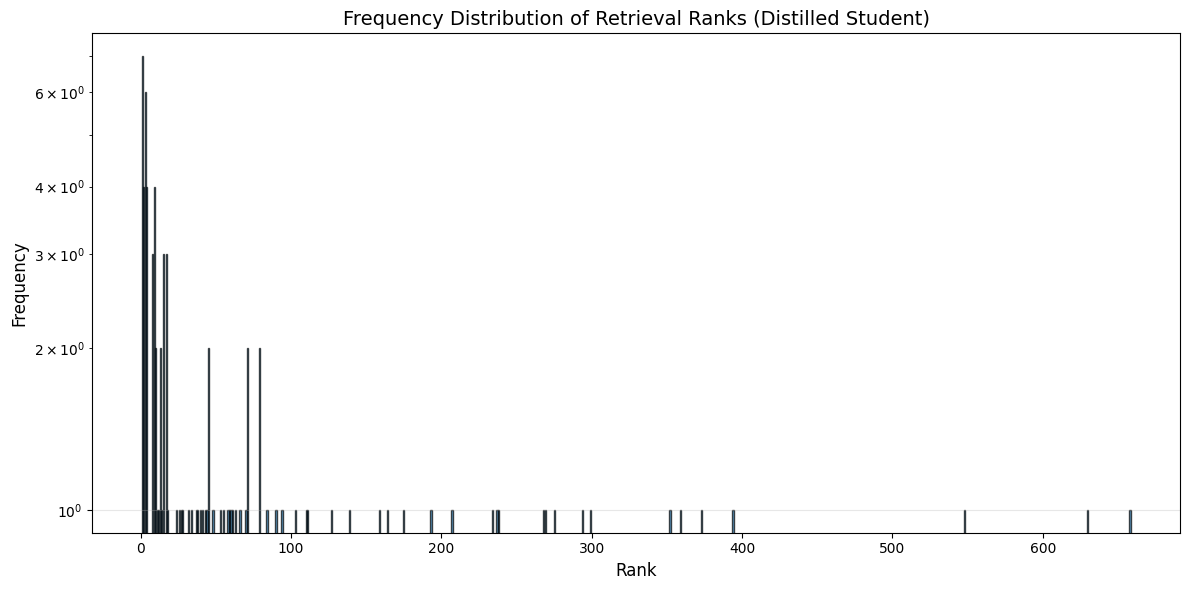

Rank range: 1 to 658
Most common ranks: [(1, 7), (3, 6), (4, 4), (2, 4), (9, 4), (15, 3), (17, 3), (8, 3), (45, 2), (13, 2)]


In [9]:
from collections import Counter

import matplotlib.pyplot as plt

# Count frequency of each rank
rank_counts = Counter(ranks)

# Sort by rank
sorted_ranks = sorted(rank_counts.keys())
frequencies = [rank_counts[r] for r in sorted_ranks]

# Create bar plot
plt.figure(figsize=(12, 6))
plt.bar(sorted_ranks, frequencies, edgecolor='black', alpha=0.7)
plt.xlabel('Rank', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Frequency Distribution of Retrieval Ranks (Distilled Student)', fontsize=14)
plt.yscale('log')  # log scale to see smaller frequencies
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Print summary statistics
print(f"Rank range: {min(sorted_ranks)} to {max(sorted_ranks)}")
print(f"Most common ranks: {rank_counts.most_common(10)}")
